# Random Number Generation

Random number genaration is the process of generating random numbers. This can mean the generation of one random number or a sequence of random numbers. Random number generators are devices which produce random numbers. There are hardware random number generators, which are true random number generators. And there are pseudo-random number generators (PRNG), which produce sequences of radnom numbers that look random but are in effect not random and can be reproduced if the state of the PRNG is known. PRNG are often implemented in software.

The generation of random numbers with software is usually not truely random in it's nature. Why is that? Mainly because a computer doesn't have enough "randomness" available to generate large sequences of random numbers. Surely, there is a enough randomness to generate a random number "every now and then". Just take the milliseconds of the current system time, e.g. to sample a random number from the uniform distribution over $[0, 1]$. However, often we want to generate sequences - and possibly even large sequences - of random numbers during a "non-random" time interval. While there are other sources of randomness available to a computer, like some hardware input, human input or network trafic, it's often not enough to provide "true randomness" for sampling many random numbers in short time intervals. 

For this purpose, PRNG generate number sequences that look random but are, in effect, deterministic. PRNG are usually initialized with a truely random number. However, the entropy of a sequence of pseudo-random numbers generated by a PRNG can't be higher than the entropy of the random initialization of the PRNG. The PRNG "cleverly" hides the relatively low entropy by making the number sequence look random. But it is not. Would we know the type of PRNG and its initialization, we could then easily recreate that particular number sequence. That's why these numbers are pseudo-random.

When we want to generate a random number, we want to sample that number from a particular distribution $P$. Most algorithms for sampling random numbers actually only require a sequence of random numbers $x_{i=1}^{n}$ from the uniform distribution over the real interval $[0, 1] \subseteq ℝ$. They then use $x_{i=1}^{n}$ to generate the random number from the desired distribution. There is a theoretical results which says that any distribution over the real number can be composed of the uniform distribution over $[0, 1]$ and a "gluing" function.

In other words, that means that we need to have a robust PRNG to generate a sequence of random numbers from the uniform distribution over $[0, 1]$. The "gluing" function we can then find in the form of a clever algorithm. 


## Linear Congruential Generator

Software PRNG are often recursive. That means that the calculation of the next number of the sequence involves the current number generated by the sequence. One example is the linear congruential  generator, which generates the next number like 

$$x_i = (a x_{i - 1} + b) \mod n$$

where $a,b,m \in ℕ$ and have to be set upon initialization and are fullfil

 * $0 < m$, the modulus
 * $0 < a < m$, the multiplier
 * $0 ≤ b < m$, the increment
 * $0 ≤ x_0 < m$, the start value or seed
 
Let's implement a linear congruential generator and use it to draw pseudo-random numbers that shall be equally distributed in the interval $[0, 1]$. 

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from typing import List

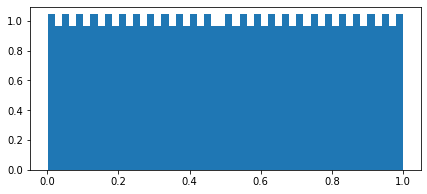

In [57]:
class RandUniform(object):
    def __init__(self, a: int, b: int, m: int, first: int):
        self.a = a
        self.b = b
        self.m = m
        self.last = first
           
    def next(self) -> int:
        next = (self.a * self.last + self.b) % self.m
        self.last = next
        return next
    
    def sample(self, n: int) -> np.ndarray:
        return np.full(shape=(n,), fill_value=[self.next() for _ in range(n)])
    
rand_sample = RandUniform(a=106, b=523, m=10000, first=82).sample(n=1000000)

plt.figure(figsize=(7,3))
plt.hist(rand_sample * (1 / 10000), density=True, bins=50)
plt.show()

## Rejection Sampling

One algorithm to sample from any probability distribution is $P$ the rejection sampling algorithm.

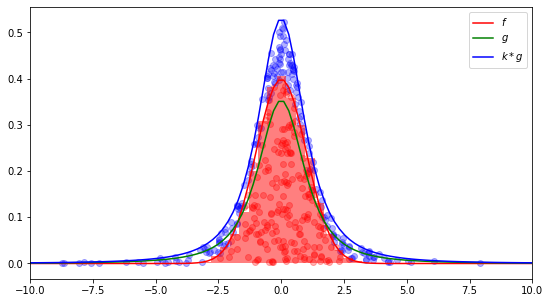

Fraction rejected samples: 0.3368


In [58]:
f = stats.norm(0, 1)
g = stats.t(df=2)
uniform = stats.uniform()
k = 1.5

t = np.linspace(-10, 10, 100)
plt.figure(figsize=(9, 5))
plt.plot(t, f.pdf(t), label='$f$', color='red')
plt.plot(t, g.pdf(t), label='$g$', color='green')
plt.plot(t, k*g.pdf(t), label='$k*g$', color='blue')
plt.legend()

n = 10000

u = uniform.rvs(n)
x = g.ppf(u)  # inverse of cdf
y = uniform.rvs(n) * k * g.pdf(x)

y_accepted = y[y < f.pdf(x)]
x_accepted = x[y < f.pdf(x)]
y_rejected = y[y >= f.pdf(x)]
x_rejected = x[y >= f.pdf(x)]

s = slice(0, 200)
plt.scatter(x_accepted[s], y_accepted[s], color='red', alpha=0.3)
plt.scatter(x_rejected[s], y_rejected[s], color='blue', alpha=0.3)
plt.xlim((-10, 10))

plt.hist(x_accepted, density=True, alpha=0.5, bins=20, color='red')
plt.show()

print(f'Fraction rejected samples: {len(x_rejected) / n}')

## Metropolis-Hastings Sampling